# Playground Notebook for Developing Algorithms

## Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import math
import torch
import tqdm.notebook as tqdm
import sys
if sys.platform == "win32":
    sys.path.insert(
        0,
        "C:\\Users\\twilkeni\\AppData\\Local"
        + "\\anaconda3\\envs\\pytorch-env\\site-packages",
    )
import gpytorch
# from qwiic_ads1115.qwiic_ads1115 import QwiicAds1115
import time
# import pyro
# from pyro.infer.mcmc import NUTS, MCMC, HMC
# from copy import deepcopy
# from functools import partial
# from scipy.stats import multivariate_normal

## GP Model on the Test Data Collected on Jetbot

### Import and Visualize Training Data

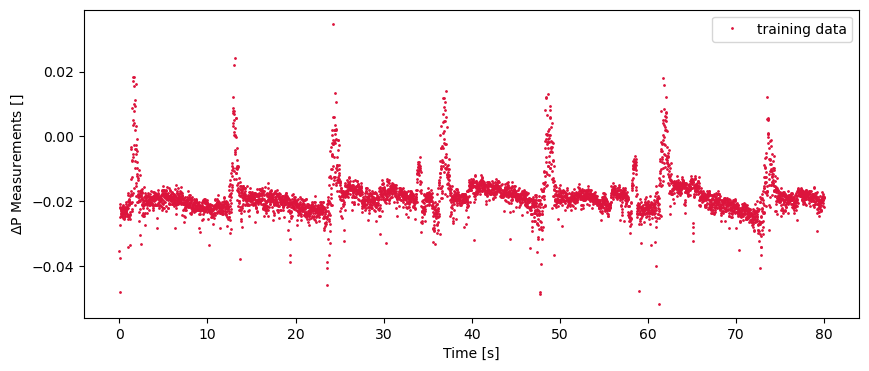

In [2]:
df = pd.read_csv('data/sample_data_2024_04_28T220150.csv',header=None)
df.columns = ["time","pdiff"]
data = df.to_numpy()
data[:,0] = data[:,0] - data[0,0] # setting start time to 0

train_x = torch.Tensor(data[:,0])
train_y = torch.Tensor(data[:,1])

fig = plt.figure(figsize=(10,4))
plt.plot(train_x.numpy(), train_y.numpy(), 'o', ms=1, color='crimson', label='training data')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel(r'$\Delta$P Measurements []')
plt.show()

### Exact GP Model - CPU

In [3]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [4]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [5]:
training_iter = 20

# Find optimal model hyperparameters (put into training mode)
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   th1: %.3f  th2: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        math.sqrt(model.covar_module.outputscale.item()),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/20 - Loss: 0.774   th1: 0.833  th2: 0.693   noise: 0.693
Iter 2/20 - Loss: 0.734   th1: 0.803  th2: 0.744   noise: 0.644
Iter 3/20 - Loss: 0.695   th1: 0.773  th2: 0.798   noise: 0.598
Iter 4/20 - Loss: 0.656   th1: 0.745  th2: 0.854   noise: 0.554
Iter 5/20 - Loss: 0.615   th1: 0.717  th2: 0.911   noise: 0.513
Iter 6/20 - Loss: 0.573   th1: 0.690  th2: 0.971   noise: 0.474
Iter 7/20 - Loss: 0.532   th1: 0.663  th2: 1.032   noise: 0.437
Iter 8/20 - Loss: 0.491   th1: 0.637  th2: 1.094   noise: 0.403
Iter 9/20 - Loss: 0.449   th1: 0.612  th2: 1.157   noise: 0.370
Iter 10/20 - Loss: 0.406   th1: 0.588  th2: 1.222   noise: 0.340
Iter 11/20 - Loss: 0.360   th1: 0.564  th2: 1.287   noise: 0.312
Iter 12/20 - Loss: 0.314   th1: 0.542  th2: 1.353   noise: 0.286
Iter 13/20 - Loss: 0.271   th1: 0.520  th2: 1.419   noise: 0.261
Iter 14/20 - Loss: 0.223   th1: 0.499  th2: 1.486   noise: 0.239
Iter 15/20 - Loss: 0.177   th1: 0.479  th2: 1.553   noise: 0.218
Iter 16/20 - Loss: 0.131   th1: 0.

In [6]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

new_end = round(data[-1,0]) + 5
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(start=60,end=new_end,steps=20*25)
    observed_pred = model.likelihood(model(test_x))

In [17]:
test_x.numpy().reshape(1, -1).shape

(1, 500)

In [10]:
observed_pred.mean.numpy().T.shape

(500,)

In [20]:
np.vstack((test_x.numpy().reshape(1, -1), observed_pred.mean.numpy().reshape(1,-1))).shape

(2, 500)

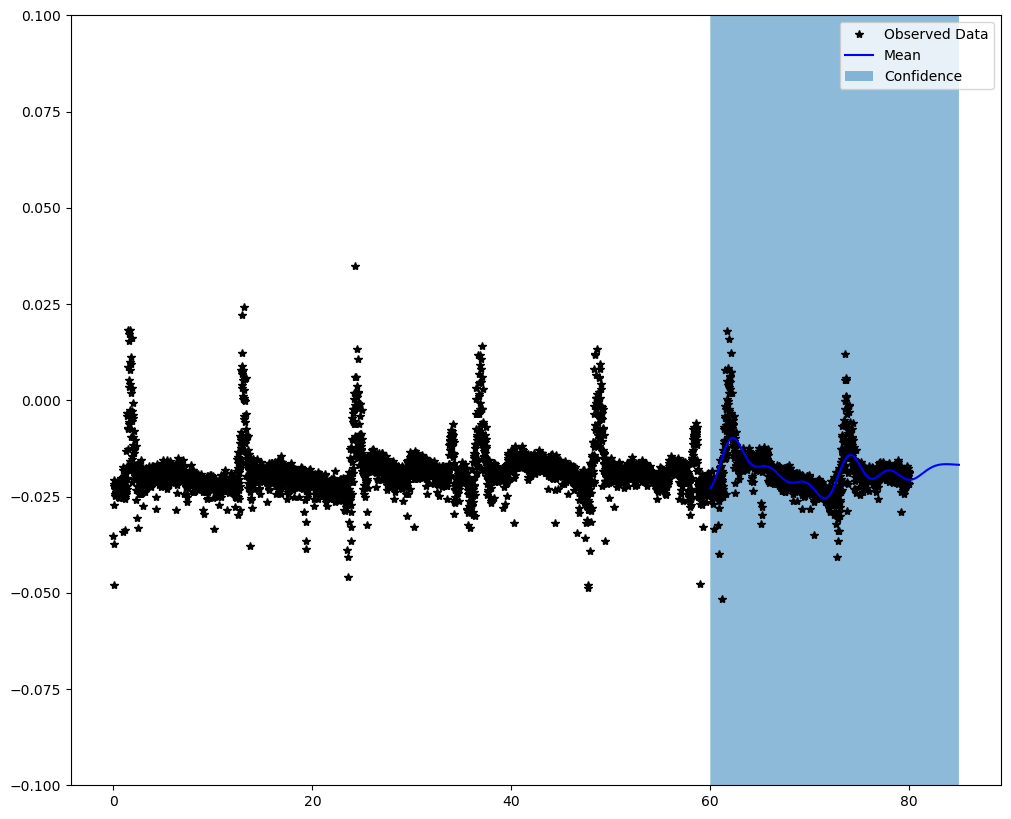

In [7]:
# Plotting Results!
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(12, 10))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-0.1, 0.1])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    # ax.set_xlim([1990, 2000])

### Sparse GP Model - CPU

In [3]:
train_x.numpy().shape

(5120,)

In [30]:
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel
from gpytorch.distributions import MultivariateNormal

class SGPRModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(SGPRModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.base_covar_module = ScaleKernel(RBFKernel())
        self.covar_module = InducingPointKernel(self.base_covar_module, inducing_points=train_x[:500].clone(), likelihood=likelihood)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [31]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = SGPRModel(train_x, train_y, likelihood)

In [32]:
training_iter = 25

# Find optimal model hyperparameters (put into training mode)
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

iterator = tqdm.tqdm(range(training_iter), desc="Train")

for i in iterator:
    # Zero backprop gradients
    optimizer.zero_grad()
    # Get output from model
    output = model(train_x)
    # Calc loss and backprop derivatives
    loss = -mll(output, train_y)
    loss.backward()
    iterator.set_postfix(loss=loss.item())
    print('Iter %d/%d - Loss: %.3f   th1: %.3f  th2: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        math.sqrt(model.covar_module.base_kernel.outputscale.item()),
        model.covar_module.base_kernel.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()
    # torch.cuda.empty_cache()


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Iter 1/25 - Loss: 1.184   th1: 0.833  th2: 0.693   noise: 0.693
Iter 2/25 - Loss: 1.180   th1: 0.830  th2: 0.698   noise: 0.688
Iter 3/25 - Loss: 1.176   th1: 0.827  th2: 0.703   noise: 0.683
Iter 4/25 - Loss: 1.172   th1: 0.824  th2: 0.708   noise: 0.678
Iter 5/25 - Loss: 1.168   th1: 0.821  th2: 0.713   noise: 0.673
Iter 6/25 - Loss: 1.165   th1: 0.818  th2: 0.718   noise: 0.669
Iter 7/25 - Loss: 1.161   th1: 0.815  th2: 0.724   noise: 0.664
Iter 8/25 - Loss: 1.157   th1: 0.812  th2: 0.729   noise: 0.659
Iter 9/25 - Loss: 1.153   th1: 0.809  th2: 0.734   noise: 0.654
Iter 10/25 - Loss: 1.149   th1: 0.806  th2: 0.739   noise: 0.649
Iter 11/25 - Loss: 1.146   th1: 0.803  th2: 0.744   noise: 0.644
Iter 12/25 - Loss: 1.142   th1: 0.800  th2: 0.750   noise: 0.640
Iter 13/25 - Loss: 1.138   th1: 0.797  th2: 0.755   noise: 0.635
Iter 14/25 - Loss: 1.134   th1: 0.794  th2: 0.760   noise: 0.630
Iter 15/25 - Loss: 1.130   th1: 0.791  th2: 0.766   noise: 0.626
Iter 16/25 - Loss: 1.126   th1: 0.

In [36]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

new_end = round(data[-1,0]) + 5
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(start=40,end=new_end,steps=20*(85-40))
    observed_pred = model.likelihood(model(test_x))

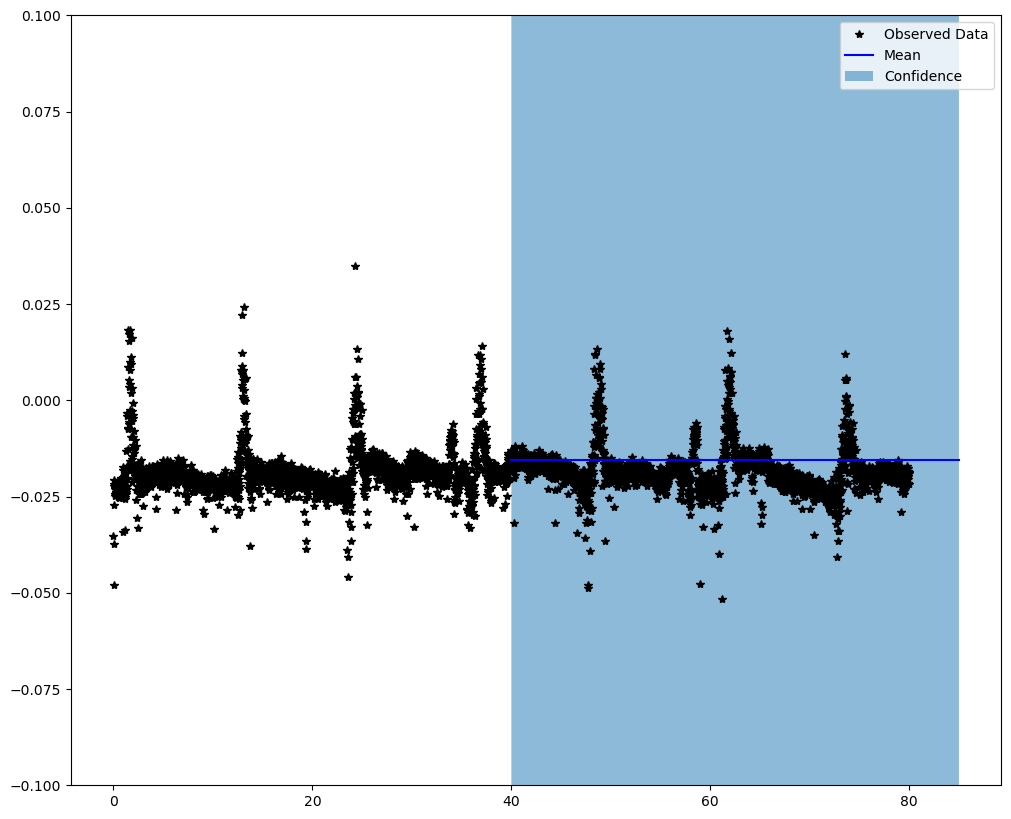

In [37]:
# Plotting Results!
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(12, 10))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-0.1, 0.1])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    # ax.set_xlim([1990, 2000])

### Exact GP Model - GPU

In [41]:
class ExactGPModelGPU(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModelGPU, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [43]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModelGPU(train_x, train_y, likelihood)

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()
    train_x, train_y = train_x.cuda(), train_y.cuda()

In [46]:
training_iter = 20

# Find optimal model hyperparameters (put into training mode)
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

iterator = tqdm.tqdm(range(training_iter), desc="Train")

for i in iterator:
    # Zero backprop gradients
    optimizer.zero_grad()
    # Get output from model
    output = model(train_x)
    # Calc loss and backprop derivatives
    loss = -mll(output, train_y)
    loss.backward()
    iterator.set_postfix(loss=loss.item())
    print('Iter %d/%d - Loss: %.3f   th1: %.3f  th2: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        math.sqrt(model.covar_module.outputscale.item()),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()
    torch.cuda.empty_cache()

Train:   0%|          | 0/20 [00:00<?, ?it/s]

Iter 1/20 - Loss: 0.772   th1: 0.833  th2: 0.693   noise: 0.693
Iter 2/20 - Loss: 0.734   th1: 0.803  th2: 0.744   noise: 0.644
Iter 3/20 - Loss: 0.697   th1: 0.773  th2: 0.798   noise: 0.598
Iter 4/20 - Loss: 0.653   th1: 0.745  th2: 0.853   noise: 0.554
Iter 5/20 - Loss: 0.614   th1: 0.717  th2: 0.911   noise: 0.513
Iter 6/20 - Loss: 0.575   th1: 0.689  th2: 0.970   noise: 0.474
Iter 7/20 - Loss: 0.531   th1: 0.663  th2: 1.030   noise: 0.437
Iter 8/20 - Loss: 0.490   th1: 0.637  th2: 1.092   noise: 0.403
Iter 9/20 - Loss: 0.449   th1: 0.612  th2: 1.154   noise: 0.370
Iter 10/20 - Loss: 0.405   th1: 0.588  th2: 1.218   noise: 0.340
Iter 11/20 - Loss: 0.360   th1: 0.564  th2: 1.284   noise: 0.312
Iter 12/20 - Loss: 0.315   th1: 0.541  th2: 1.350   noise: 0.286
Iter 13/20 - Loss: 0.270   th1: 0.519  th2: 1.418   noise: 0.261
Iter 14/20 - Loss: 0.225   th1: 0.498  th2: 1.486   noise: 0.239
Iter 15/20 - Loss: 0.178   th1: 0.478  th2: 1.555   noise: 0.218
Iter 16/20 - Loss: 0.130   th1: 0.

In [53]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

new_end = round(data[-1,0]) + 5
# Make predictions by feeding model through likelihood
# with torch.no_grad(), gpytorch.settings.fast_pred_var():
with torch.no_grad():
    test_x = torch.linspace(start=30,end=new_end,steps=10*(85-30)).cuda()
    observed_pred = likelihood(model(test_x))

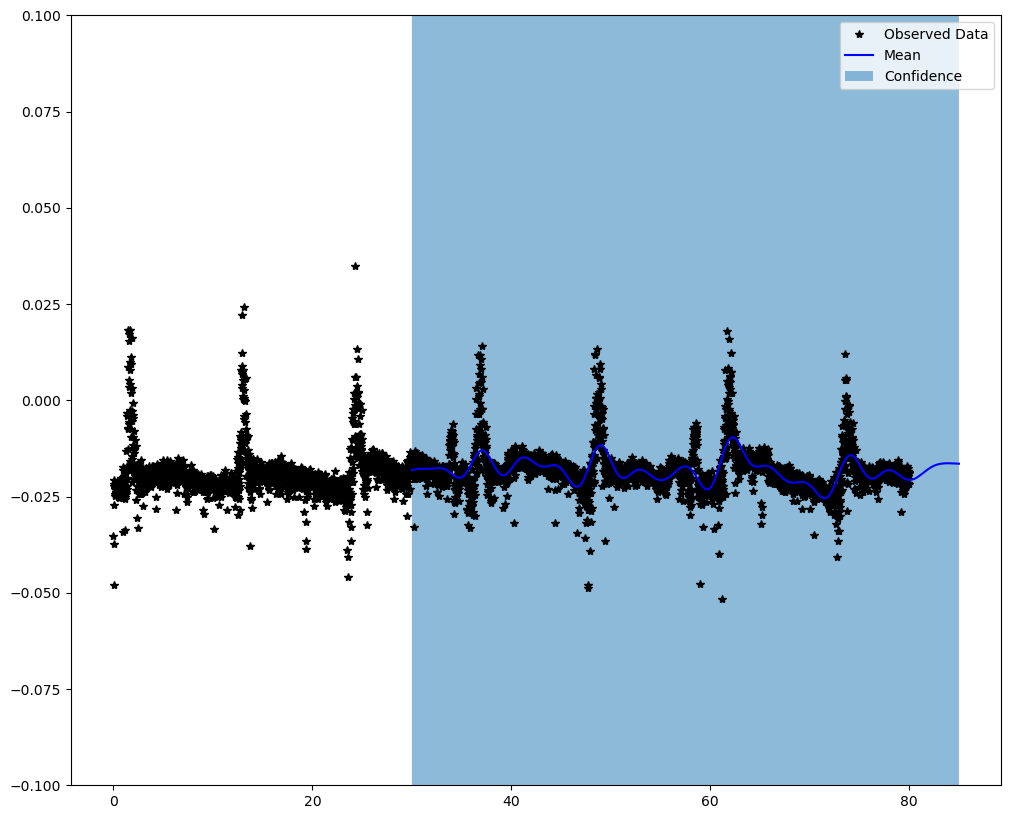

In [54]:
# bring test and training data back to cpu
train_x = train_x.cpu()
train_y = train_y.cpu()
test_x = test_x.cpu()

# Plotting Results!
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(12, 6))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    ax.set_ylim([-0.05, 0.05])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    # ax.set_xlim([1990, 2000])

## Generate Fake Data

In [14]:
# absolute of a sine wave, with a small amplitude and a long period

tlen = 45  # seconds
ts = 1/8  # ~8 samples per second
t = np.arange(0,tlen,ts)
period = tlen/2
amp = 0.04
mean = -0.02
omega = 2*np.pi/period  # frequency [rad/s]

obs = mean + amp*abs(np.sin(t*omega)) + \
    np.random.randn(t.shape[0]) * amp/8


# initialize data and noise array
data_fake = np.hstack((t.reshape(-1, 1), obs.reshape(-1,1)))


In [15]:
data_fake.shape

(360, 2)

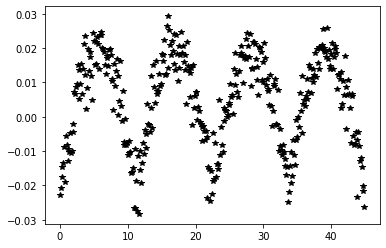

In [16]:
fix, ax = plt.subplots()
plt.plot(data_fake[:,0], data_fake[:,1],'k*')
plt.show()

## Exact GP Model - CPU - Based on Fake Data

In [27]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

torch.set_default_dtype(torch.float64)

In [28]:
train_x = torch.from_numpy(data_fake[:, 0].astype(np.float64))
train_y = torch.from_numpy(data_fake[:, 1].astype(np.float64))
# normalize the target values to [-1 1]
max_y = max(abs(train_y))
train_y = train_y/max_y
# initialize likelihood and model
# Create a GaussianLikelihood with a normal prior for the noise
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint=gpytorch.constraints.GreaterThan(1e-3),
    noise_prior=gpytorch.priors.NormalPrior(0, 0.1)
)
likelihood.noise_covar.noise = torch.tensor(0.04)
model = ExactGPModel(train_x, train_y, likelihood)

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()
    train_x, train_y = train_x.cuda(), train_y.cuda()

In [29]:
training_iter = 100

# Find optimal model hyperparameters (put into training mode)
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   th1: %.3f  th2: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        math.sqrt(model.covar_module.outputscale.item()),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/100 - Loss: -0.019   th1: 0.833  th2: 0.693   noise: 0.040
Iter 2/100 - Loss: -0.051   th1: 0.803  th2: 0.744   noise: 0.036
Iter 3/100 - Loss: -0.076   th1: 0.773  th2: 0.798   noise: 0.033
Iter 4/100 - Loss: -0.097   th1: 0.745  th2: 0.854   noise: 0.030
Iter 5/100 - Loss: -0.114   th1: 0.717  th2: 0.912   noise: 0.028
Iter 6/100 - Loss: -0.127   th1: 0.689  th2: 0.971   noise: 0.026
Iter 7/100 - Loss: -0.138   th1: 0.663  th2: 1.032   noise: 0.025
Iter 8/100 - Loss: -0.149   th1: 0.638  th2: 1.094   noise: 0.025
Iter 9/100 - Loss: -0.159   th1: 0.613  th2: 1.157   noise: 0.025
Iter 10/100 - Loss: -0.170   th1: 0.590  th2: 1.221   noise: 0.025
Iter 11/100 - Loss: -0.180   th1: 0.567  th2: 1.285   noise: 0.026
Iter 12/100 - Loss: -0.188   th1: 0.546  th2: 1.348   noise: 0.027
Iter 13/100 - Loss: -0.194   th1: 0.526  th2: 1.411   noise: 0.028
Iter 14/100 - Loss: -0.199   th1: 0.507  th2: 1.473   noise: 0.029
Iter 15/100 - Loss: -0.202   th1: 0.489  th2: 1.533   noise: 0.030
Iter

In [30]:
# convert back to cpu
if torch.cuda.is_available():
    model = model.cpu()
    likelihood = likelihood.cpu()
    train_x, train_y = train_x.cpu(), train_y.cpu()

In [31]:
torch.save(model.state_dict(), 'data/model_state_test.pth')
torch.save(train_x, 'data/train_x.pth')
torch.save(train_y, 'data/train_y.pth')
del train_x, train_y, model

In [32]:
train_x = torch.load('data/train_x.pth')
train_y = torch.load('data/train_y.pth')
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint=gpytorch.constraints.GreaterThan(1e-3),
    noise_prior=gpytorch.priors.NormalPrior(0, 0.1)
)
model = ExactGPModel(train_x, train_y, likelihood)
state_dict = torch.load('data/model_state_test.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [33]:
torch.get_default_dtype()

torch.float64

In [35]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

new_end = round(data_fake[-1,0]) + 5
test_x = torch.linspace(0,new_end,int(new_end/0.1), dtype=torch.float32)  # 10 pts/sec

# Make predictions by feeding model through likelihood
# with torch.no_grad(), gpytorch.settings.fast_pred_var():
with torch.no_grad():
    observed_pred = model.likelihood(model(train_x))

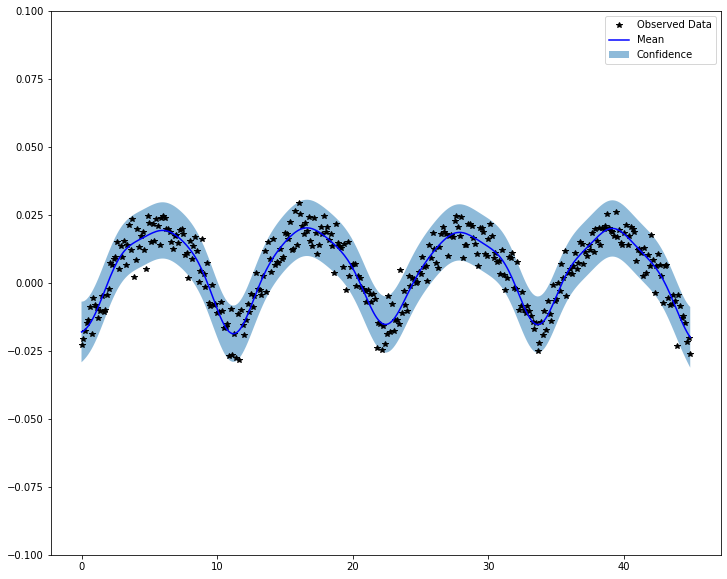

In [36]:
# Plotting Results!
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(12, 10))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    scale = max_y.numpy()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy()*scale, 'k*')
    # Plot predictive means as blue line
    # ax.plot(test_x.numpy(), observed_pred.mean.numpy()*scale, 'b')
    ax.plot(train_x.numpy(), observed_pred.mean.numpy()*scale, 'b')
    # Shade between the lower and upper confidence bounds
    # ax.fill_between(test_x.numpy(), lower.numpy()*scale, upper.numpy()*scale, alpha=0.5)
    ax.fill_between(train_x.numpy(), lower.numpy()*scale, upper.numpy()*scale, alpha=0.5)
    ax.set_ylim([-0.1, 0.1])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])


## ADS1115 Initialization and Calibration

In [9]:
ads = QwiicAds1115()
ads.os = '0' # no effect
ads.mux = '100' # Analog In, channel 0, compare to GND
ads.gain = '000' # +/- 6.144V
ads.mode = '0' # continuous
ads.data_rate = '100' # 128 SPS
ads.comp_que = '11' # disable comparator
ads.scale = 1 # 1V = 1kPa delta between ports
if ads.is_connected():
    ads.configure()
    time.sleep(0.5)
    ads.calibrate()
    
    # Confirm calibration set:
    if abs(ads.get_measurement()) > 0.1:
        print("Pressure calibration has likely failed")
    else:
        print("ADS1115 successfully initialized and calibrated")
else:
    print("ADS1115 not connected")

ADS1115 successfully initialized and calibrated


In [13]:
def velocity(pressure_diff,rho=1.204):
    """VELOCITY calculates the velocity of the airflow given a pitot
    pressure difference measurement. Calculates velocity regardless
    of whether the pitot tube is setup for positive voltage output
    on the ADC, or negative voltage output (based on how the pressure
    tubes are connected to the pressure sensor).

    Args:
        pressure_diff (float): total pressure - static pressure [kPa]
            (output of MPXV7002 is 1V/kPa)
        rho (float): density of the fluid [kg/m^3]
            (1.204 kg/m3 at sea level per International Standard
            Atmosphere)
    Returns:
        vel (float): calculated velocity [m/s]
    """
    # calculate velocity per the following resource:
    # https://www.grc.nasa.gov/www/k-12/VirtualAero/BottleRocket/airplane/pitot.html
    vel = np.sqrt(2*abs(pressure_diff) / rho)
    return vel

In [14]:
velocity(ads.get_measurement())

0.10384029713444146

In [15]:
ads.get_measurement()

-0.004053749999999745